# Produce lifetime XY map and write a dst corrected by lifetime and energy scale

### Run number

In [1]:
import os

run_number          = 6202

input_dst_filename  = os.path.expandvars(f"$IC_DATA/dst/dst_{run_number}.h5")
lt_filename         = os.path.expandvars(f"$IC_DATA/maps/lt_{run_number}.h5")
output_dst_filename = os.path.expandvars(f"$IC_DATA/ldst/dst_{run_number}.h5")

print(f"run number  = {run_number}")
print(f"input dst   = {input_dst_filename}")
print(f"lt_filename ={lt_filename}")
print(f"output dst  ={output_dst_filename}")

run number  = 6202
input dst   = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6202.h5
lt_filename =/Users/jjgomezcadenas/Projects/ICDATA/maps/lt_6202.h5
output dst  =/Users/jjgomezcadenas/Projects/ICDATA/ldst/dst_6202.h5


### Notebook configuration

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
# Plotting style
default_cmap = "jet"

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [4]:
import os
import time
import datetime
import collections
import glob

import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
import invisible_cities.reco    .corrections    as corrf

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [5]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import kr_event
from core.kr_types import kr_times_ranges_and_bins
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from core.kr_types import DstEvent, NevtDst

from   invisible_cities.evm  .ic_containers  import Measurement

In [6]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [7]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [8]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [9]:
from typing      import NamedTuple

In [10]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

In [11]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Sat Jul 14 11:20:35 2018


### Local data classes

In [12]:
class Ndst(NamedTuple):
    full  : int
    fid   : int
    core  : int
    hcore : int


class EffDst(NamedTuple):
    full  : float
    fid   : float
    core  : float
    hcore : float

In [13]:
def plot_time_stamps(dst, ts, tbins, tranges, figsize=(6,6)):
    xfmt = md.DateFormatter('%d-%m %H:%M')
    fig = plt.figure(figsize=figsize)
    x, y, yu = fitf.profileX(dst.time, dst.S2e, tbins, tranges)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.xaxis.set_major_formatter(xfmt)
    plt.errorbar(ts, y, yu, fmt="kp", ms=7, lw=3)
    plt.xlabel('date')
    plt.ylabel('S2 (pes)')
    plt.xticks( rotation=25 )


### Read data

In [14]:
#dst = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
dst            = dstf.load_dst(input_dst_filename, "DST", "Events")

In [15]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 1057932


In [16]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [17]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   40,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

In [18]:
print(krRanges, krNBins)

KrRanges(Z=(100, 550), XY=(-200, 200), E=(2000.0, 15000.0), S1=(0, 30), Q=(100, 1500), T=(1531175785.2030001, 1531230190.7609999)) KrNBins(Z=10, XY=40, E=50, S1=20, Q=25, T=15)


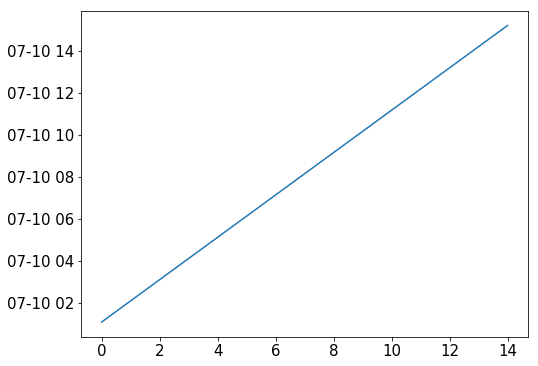

In [19]:
plt.plot(krTimes.timeStamps)

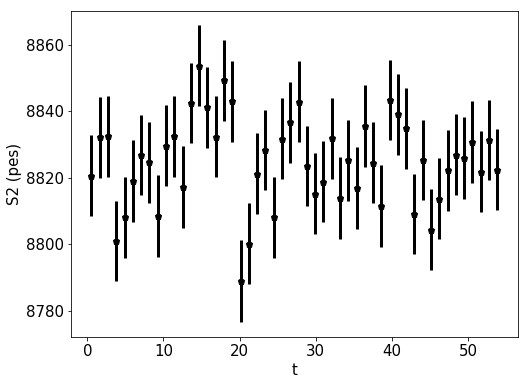

In [20]:
T   =(dst.time - dst.time.min()) 
tt = T.values/1000
t, e, eu = fitf.profileX(tt, dst.S2e, 50)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('S2 (pes)')

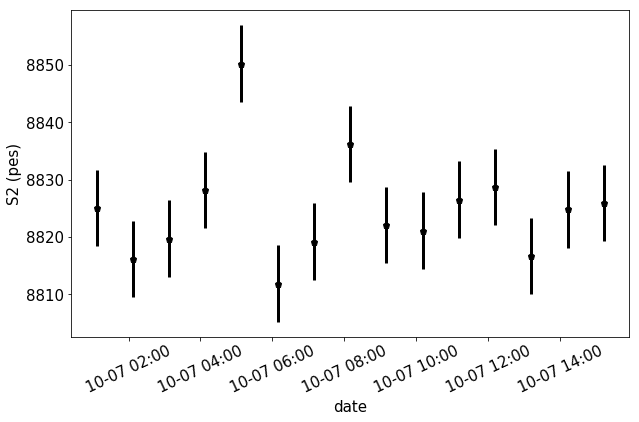

In [21]:
plot_time_stamps(dst, krTimes.timeStamps, krNBins.T, krRanges.T, figsize=(10,6))

### Fiducial volumes

In [22]:
R_full   = 200
R_fid    = 150
R_core   = 100
R_hcore  =  50
print(f" Rfull : {R_full}: Rfiducial : {R_fid}: Rcore = {R_core} Rhcore = {R_hcore} ")

 Rfull : 200: Rfiducial : 150: Rcore = 100 Rhcore = 50 


In [23]:
def fiducial_volumes(dst):
    dst_full   = dst[dst.R < R_full]
    dst_fid    = dst[dst.R < R_fid]
    dst_core   = dst[dst.R < R_core]
    dst_hcore  = dst[dst.R < R_hcore]

    n_dst  = len(dst)

    ndst = Ndst(full  = len(dst_full), 
            fid   = len(dst_fid), 
            core  = len(dst_core), 
            hcore = len(dst_hcore))

    effdst = EffDst(full  = ndst.full  / n_dst, 
                fid   = ndst.fid   / n_dst, 
                core  = ndst.core  / n_dst, 
                hcore = ndst.hcore / n_dst)
    kdst= DstEvent(full  = kr_event(dst_full),
               fid   = kr_event(dst_fid),
               core  = kr_event(dst_core),
               hcore = kr_event(dst_hcore))
    return kdst

In [24]:
kdst = fiducial_volumes(dst)

In [25]:

dst_full   = dst[dst.R < R_full]
dst_fid    = dst[dst.R < R_fid]
dst_core   = dst[dst.R < R_core]
dst_hcore  = dst[dst.R < R_hcore]

n_dst  = len(dst)

ndst = Ndst(full  = len(dst_full), 
            fid   = len(dst_fid), 
            core  = len(dst_core), 
            hcore = len(dst_hcore))

effdst = EffDst(full  = ndst.full  / n_dst, 
                fid   = ndst.fid   / n_dst, 
                core  = ndst.core  / n_dst, 
                hcore = ndst.hcore / n_dst)
print(ndst)
print(effdst)

Ndst(full=1031560, fid=566477, core=248690, hcore=62377)
EffDst(full=0.9750721218376984, fid=0.5354569102740062, core=0.23507181936079066, hcore=0.05896125648907491)


In [26]:
kdst= DstEvent(full  = kr_event(dst_full),
               fid   = kr_event(dst_fid),
               core  = kr_event(dst_core),
               hcore = kr_event(dst_hcore))

### Event distribution

### Evolution of S12 with time full

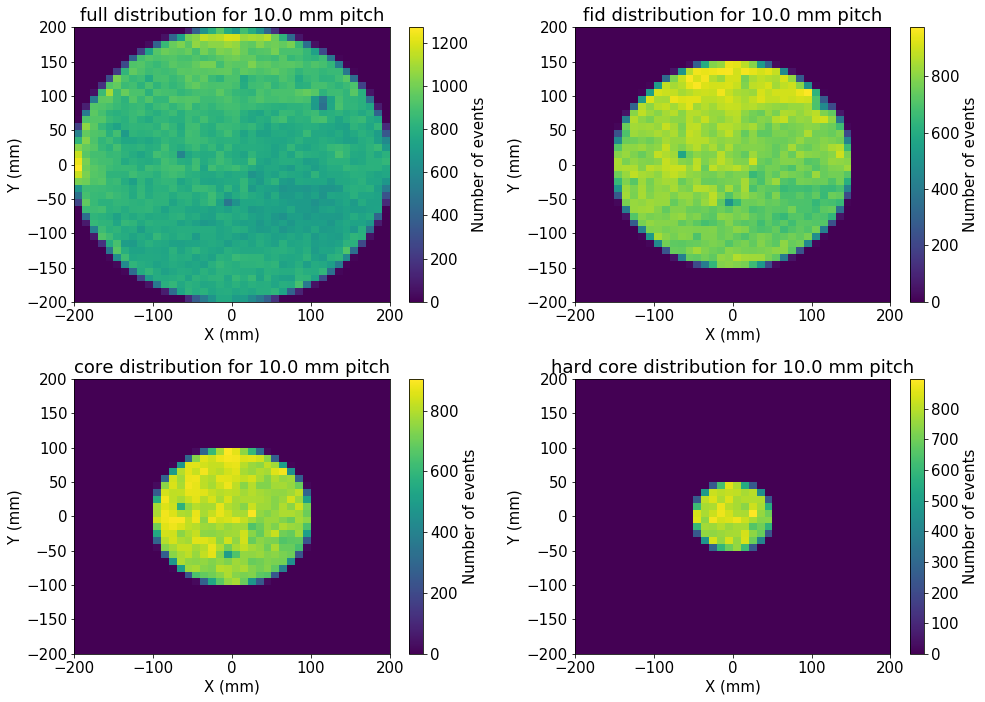

In [27]:
nEvt = krp.plot_xy_density(kdst, krBins)

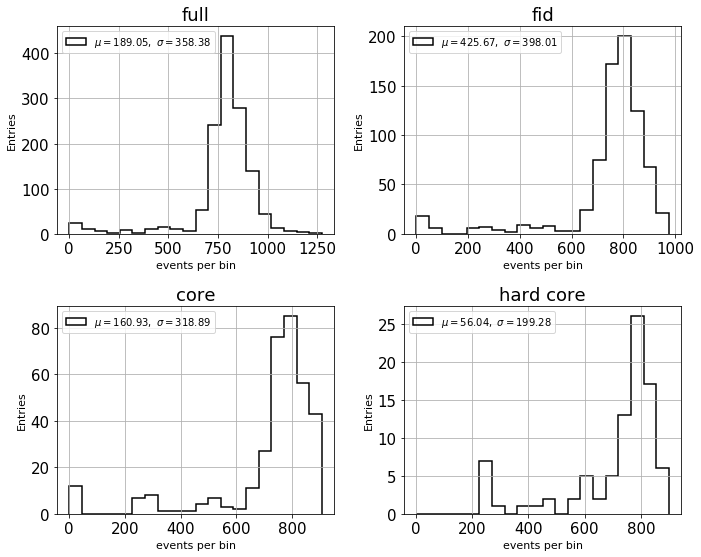

In [28]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

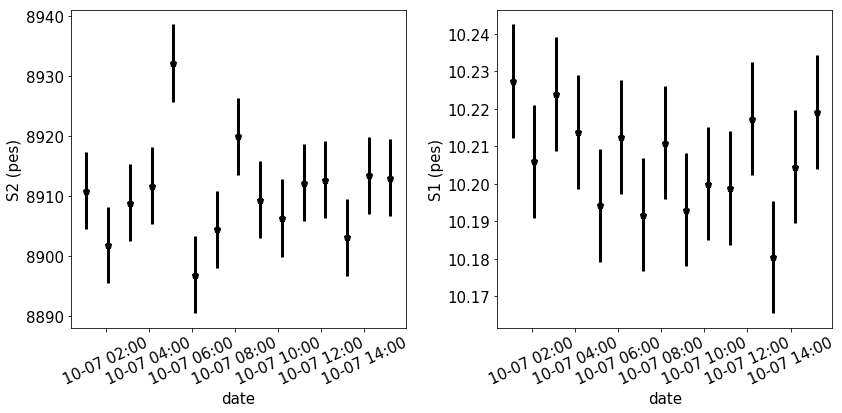

In [29]:
krf.s12_time_profile(kdst.full, krNBins.T, krRanges.T, krTimes.timeStamps, figsize=(12,6))

### Evolution of S12 with time hard core

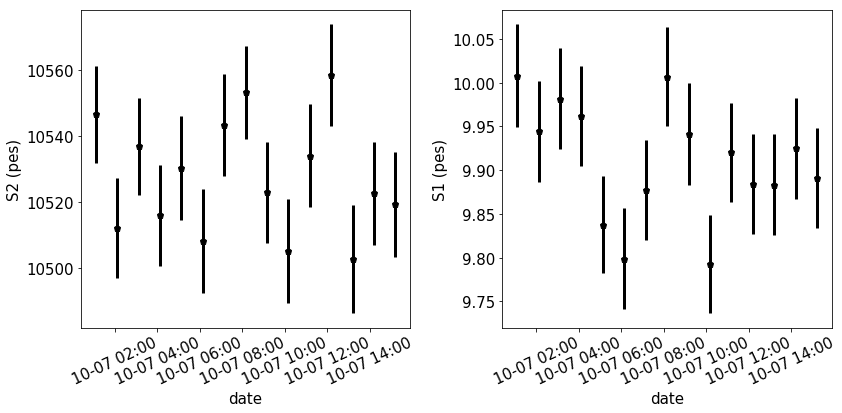

In [30]:
krf.s12_time_profile(kdst.hcore, krNBins.T, krRanges.T, krTimes.timeStamps, figsize=(12,6))

### S2 & S1 full

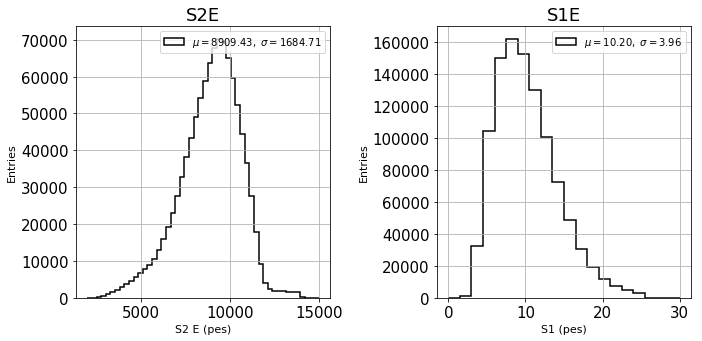

In [31]:
stats = krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.full.E, kdst.full.S1), bins=(krNBins.E, krNBins.S1), 
                names = ('S2E','S1E'),
                ranges =(krRanges.E, krRanges.S1),
                xlabels =('S2 E (pes)','S1 (pes)'),
                ylabels =('Entries','Entries'),
                titles = ('S2E','S1E'),
                legends = ('best','best'),
                figsize =(10,5))

In [32]:
stats

{'S1E': Measurement(value=10.203025649606692, uncertainty=3.9610785747906001),
 'S2E': Measurement(value=8909.433201515194, uncertainty=1684.7088282977775)}

In [33]:
krNBins

KrNBins(Z=10, XY=40, E=50, S1=20, Q=25, T=15)

In [34]:
krRanges

KrRanges(Z=(100, 550), XY=(-200, 200), E=(2000.0, 15000.0), S1=(0, 30), Q=(100, 1500), T=(1531175785.2030001, 1531230190.7609999))

In [35]:
def s1_s2_rz_cut(dst, rmax=200, zmin=0, zinterval=600):
    
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    sel = (dst.R < rmax) & (in_range(dst.Z, zmin, zmin + zinterval))
    
    plt.axes(ax[0])
    
    ax[0].set_xlabel("S2 (pes)",fontsize = 11)
    ax[0].set_ylabel("Entries", fontsize = 11)
    y, edges, _ = ax[0].hist(dst.S2e[sel],
                             bins= krNBins.E,
                             range=krRanges.E,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5)
    
    #x = shift_to_bin_centers(edges)
    
    #seed = np.max(y), x[np.argmax(y)], np.std(y)
    #f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=[x[np.argmax(y)]-1000,x[np.argmax(y)]+1000])
    #ax[0].plot(x, f.fn(x), 'r')
    #ax[0].text(4000, 0.9*np.max(y), f'R = {100*f.values[2]*2.35/f.values[1]:.2f}%')
    
    ax[1].set_xlabel("S1 (pes)",fontsize = 11)
    ax[1].set_ylabel("Entries", fontsize = 11)
    y, edges, _ = ax[1].hist(dst.S1e[sel],
                             bins= krNBins.S1,
                             range=krRanges.S1,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5)
    
    ax[2].hist2d(dst.S1e[sel], dst.S2e[sel], 100, [[0, 30],[2000, 15000]])
    ax[2].set_xlabel('S1 energy (pes)')
    ax[2].set_ylabel('S2 energy (pes)')
    fig.tight_layout()

### S2 & S1 hard core

{'S1E': Measurement(value=9.8993605349177738, uncertainty=3.6708506776038798),
 'S2E': Measurement(value=10533.079017721584, uncertainty=986.55795626708675)}

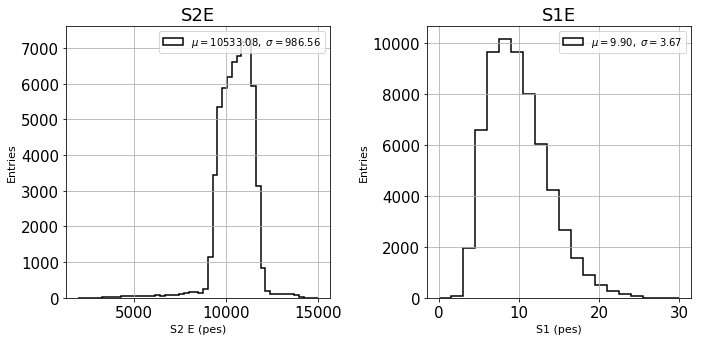

In [36]:
krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.hcore.E, kdst.hcore.S1), bins=(krNBins.E, krNBins.S1), 
        names=('S2E','S1E'),
    ranges =(krRanges.E, krRanges.S1),
    xlabels =('S2 E (pes)','S1 (pes)'),
    ylabels =('Entries','Entries'),
    titles = ('S2E','S1E'),
    legends = ('best','best'),
    figsize =(10,5))

### S2 vs Z

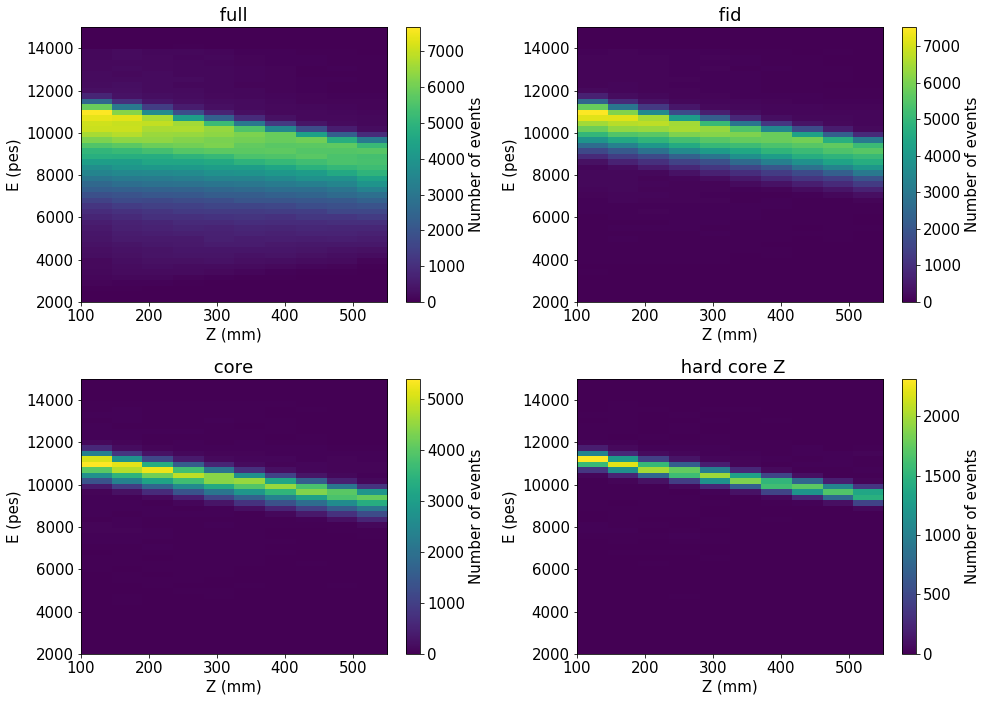

In [37]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

### Fit lifetime in hard core

 E (z=0) = 11562.21361427229 +-10.263258090169439 
 LT      = -2776.3727233649847 +-19.249122463755853 
 chi2    = 1.4618179369565663 


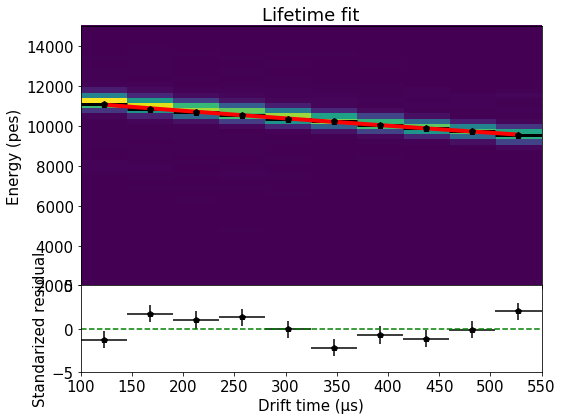

In [38]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.hcore, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit lifetime in core

 E (z=0) = 11347.213931237353 +-5.39338009329984 
 LT      = -2630.2477184078275 +-9.420962896748001 
 chi2    = 1.8494614692684548 


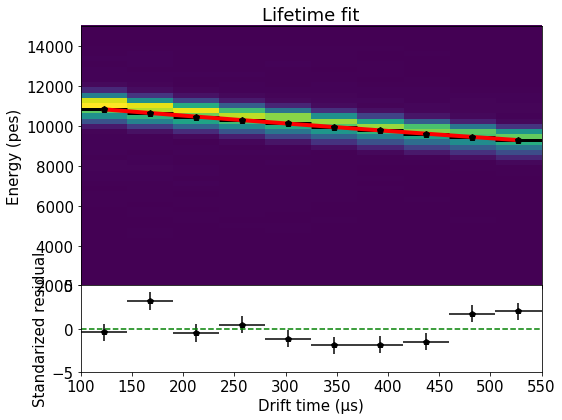

In [39]:
xlim =  -100, 100
ylim =  -100, 100
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.core, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11145.354970909644 +-20.727918063883738 
 LT      = -2562.132447974263 +-33.95126126387689 
 chi2    = 1.4731521172544504 
 E (z=0) = 10253.284212411301 +-22.700217016966768 
 LT      = -2282.60627158112 +-31.85247440117225 
 chi2    = 1.0208650896607403 
 E (z=0) = 9915.698316541098 +-20.93009284203874 
 LT      = -2269.891139724398 +-32.047990031874896 
 chi2    = 0.9465631261901702 
 E (z=0) = 10354.286919454988 +-21.822215529288233 
 LT      = -2457.417572827255 +-36.98892407021864 
 chi2    = 1.0818126639253522 


[None, None, None, None]

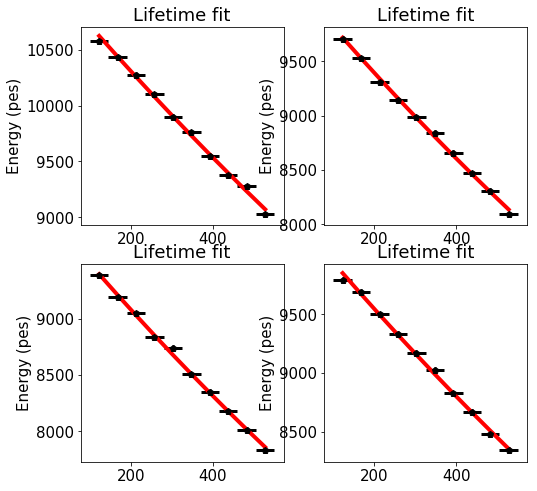

In [40]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

### Fit low and hig regions

xlim = (-100, 100), ylim =(125, 200)
xlim = (0, 200), ylim =(-50, 50)
 E (z=0) = 9680.135515754906 +-17.49204312697879 
 LT      = -2101.457388638678 +-23.391212950371735 
 chi2    = 0.7771200838169292 
 E (z=0) = 10928.041871202291 +-8.25227146232147 
 LT      = -2757.7307420338852 +-16.788605215891035 
 chi2    = 1.8278369073793104 


[None, None]

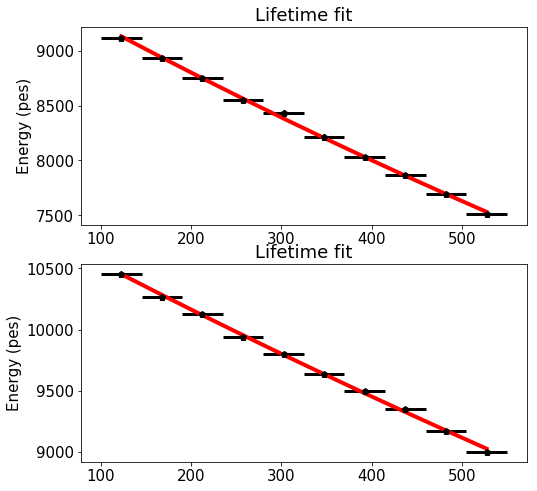

In [41]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-100, 100), (0, 200)],
                         YL = [(125, 200), (-50, 50)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

In [42]:
KF

[KrFit(par=array([ 9680.13551575, -2101.45738864]), err=array([ 17.49204313,  23.39121295]), chi2=0.77712008381692921),
 KrFit(par=array([ 10928.0418712 ,  -2757.73074203]), err=array([  8.25227146,  16.78860522]), chi2=1.8278369073793104)]

In [43]:
es_low = KF[0].par[0]
esu_low = KF[0].err[0]
es_hig = KF[1].par[0]
esu_hig = KF[1].err[0]
lt_low = np.abs(KF[0].par[1])
ltu_low = np.abs(KF[0].err[1])
lt_hig = np.abs(KF[1].par[1])
ltu_hig = np.abs(KF[1].err[1])
print(f"LOW:  es +- err = {es_low} +- {esu_low}")
print(f"High:  es +- err = {es_hig} +- {esu_hig}")
print(f"LOW:  lt +- err = {lt_low} +- {ltu_low}")
print(f"High:  lt +- err = {lt_hig} +- {ltu_hig}")

LOW:  es +- err = 9680.135515754906 +- 17.49204312697879
High:  es +- err = 10928.041871202291 +- 8.25227146232147
LOW:  lt +- err = 2101.457388638678 +- 23.391212950371735
High:  lt +- err = 2757.7307420338852 +- 16.788605215891035


### Time profile of LT in the fiducial

In [44]:
fits = krf.lifetimes_in_TRange(kdst.fid, krNBins, krBins, krRanges,  TL=krTimes.TL)

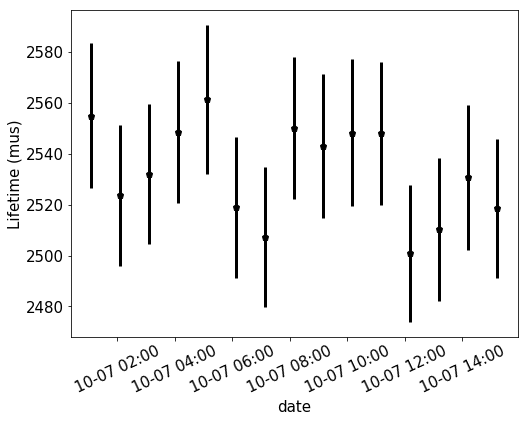

In [45]:
krp.plot_lifetime_T(fits, krTimes.timeStamps)

### Time profile of LT in hard core

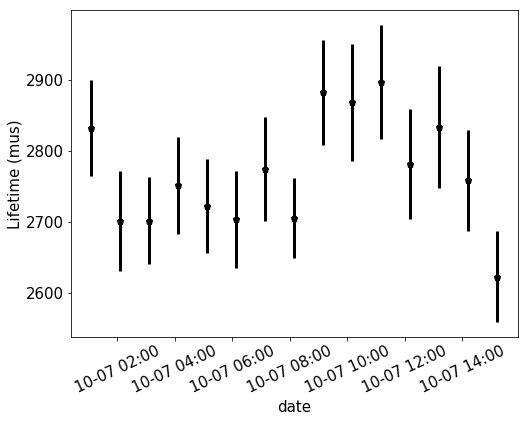

In [46]:
fits = krf.lifetimes_in_TRange(kdst.hcore, krNBins, krBins, krRanges,  TL=krTimes.TL)
krp.plot_lifetime_T(fits, krTimes.timeStamps)

### Compute lifetime maps

In [47]:
krfs = krf.fit_lifetime_slices(kdst.full, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [48]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [49]:
valid.shape

(40, 40)

In [50]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.796875

In [51]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =2256.2089608588967 +- 450.7324497945505
Lifetime uncertainty     : mu +- std =5.472842278017662 +- 2.481963766053942
Energy scale value       : mu +- std =10045.276885123134 +- 1299.323626064386
Energy scale uncertainty : mu +- std =0.9348475567702689 +- 0.6092647187184331


In [52]:
n_sigma  = 2.5
u_sigma  = 2.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 6796.9678199621685; E_max = 13293.5859502841
 Lifetime (ELT): ELT_min = 1129.3778363725205; ELT_max = 3383.040085345273
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 2.458009353566352
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 11.677751693152517


### Map display

In [53]:
invalid = ~valid
mask = valid

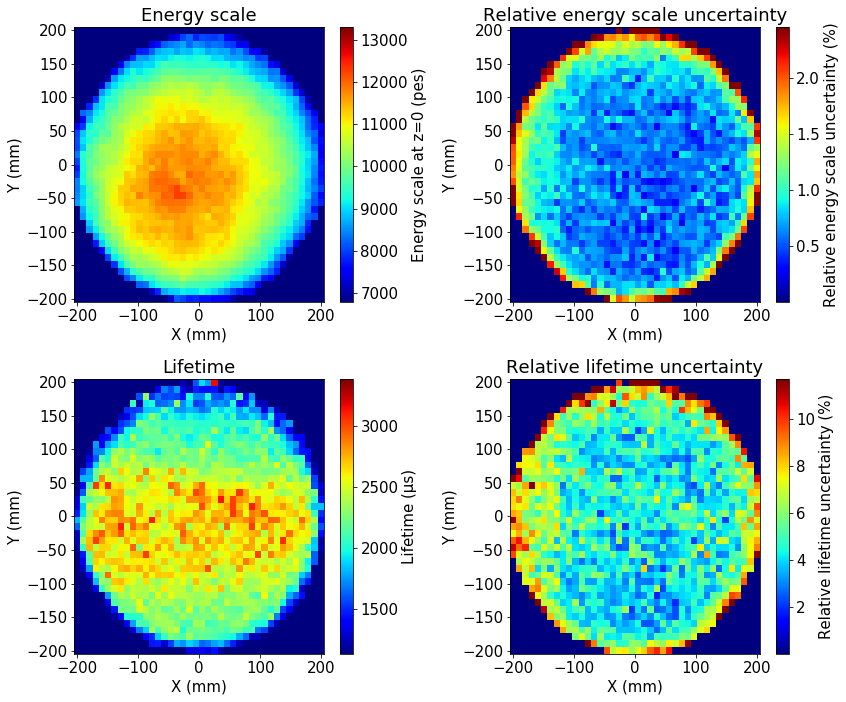

In [54]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="jet", mask=valid)
                         

(1.2011768370972911, 0.6290625544224121)

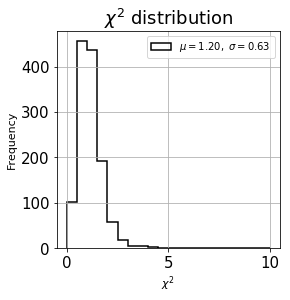

In [55]:
krp.figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

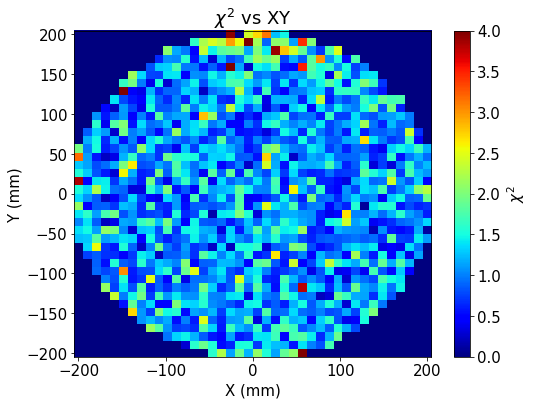

In [56]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

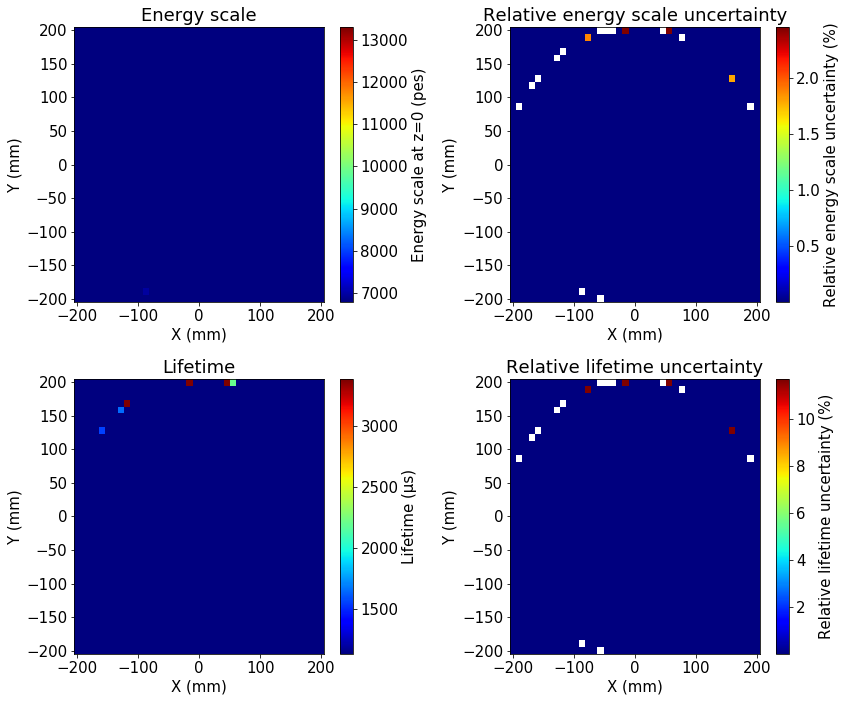

In [57]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="jet", mask=invalid)

### Fix map

- Fit fails in the corona
- Fill bins where fit has failed with average low level of lifetime


Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value      ,     Es.mu), 
                     np.where(valid, Escale_abs.uncertainty,       Es.mu_u * Es.mu / 100 ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , El.mu), 
                  np.where(valid,  ELT_abs.uncertainty,    El.mu_u * El.mu / 100))

In [58]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value ,     es_low), 
                     np.where(valid, Escale_abs.uncertainty,       esu_low ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , lt_low), 
                  np.where(valid,  ELT_abs.uncertainty,    ltu_low))

In [59]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

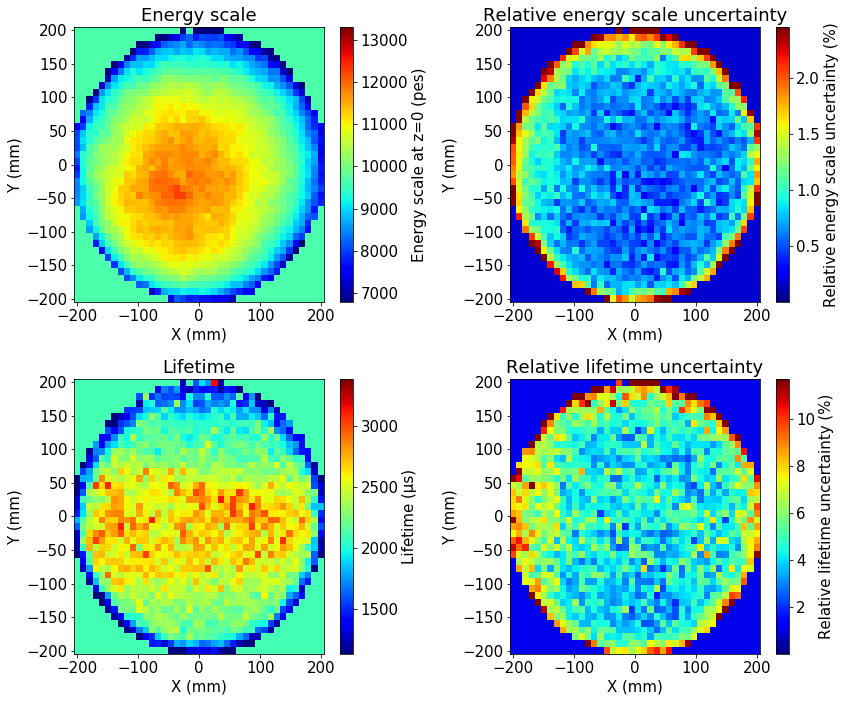

In [60]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=None)

In [61]:
gvalid   = np.zeros((krNBins.XY,krNBins.XY), dtype=bool)

In [62]:
def gfid(gvalid):
    for i in range(krNBins.XY):
        for j in range(krNBins.XY):
            if  np.sqrt(krBins.cXY[i]**2 + krBins.cXY[j]**2) < krRanges.XY[1] :
                    gvalid[i, j] = True

In [63]:
gfid(gvalid)

In [64]:
np.count_nonzero(gvalid) / (gvalid.shape[0] * gvalid.shape[1])

0.79

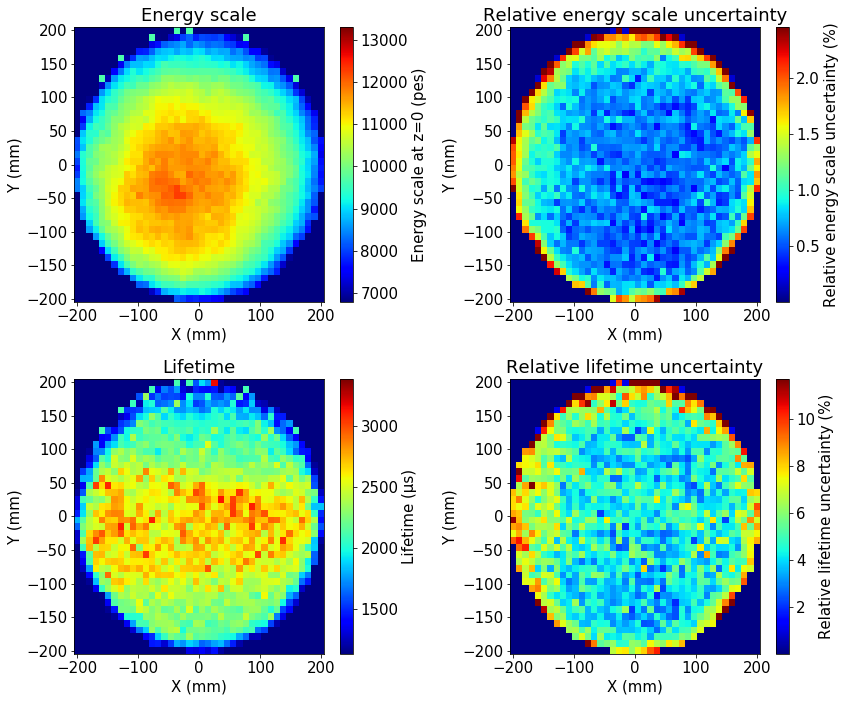

In [65]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=gvalid)

### Produce HDF5 output

In [66]:
nevt = nEvt.fid

In [67]:
print(lt_filename)

/Users/jjgomezcadenas/Projects/ICDATA/maps/lt_6202.h5


In [68]:
with tb.open_file(lt_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(krBins.cXY, krBins.cXY, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = krBins.pXY

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(krBins.cXY, krBins.cXY, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = krBins.pXY



### Load Z correction function

In [69]:
ZcorrectionE = dstf.load_lifetime_xy_corrections(lt_filename,
                                                 group = "XYcorrections",
                                                 node  = "Lifetime")

### Correct DST by lifetime

In [70]:
E = np.copy(dst.S2e.values)

In [71]:

dst.S2e = dst.S2e.values * ZcorrectionE(dst.Z, dst.X, dst.Y).value

In [72]:
Ec = dst.S2e.values

{'Ecorr ': Measurement(value=9847.8308659752965, uncertainty=1793.1336925964351),
 'Eraw ': Measurement(value=8823.742874669937, uncertainty=1768.1204606632596)}

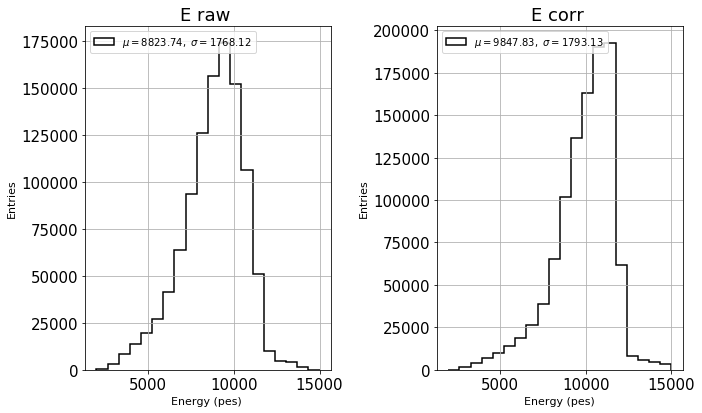

In [73]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (E, Ec),
    bins = (20, 20),
    names = ("Eraw ", "Ecorr "),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E raw ", "E corr "),
    legends = ("upper left", "upper left"),
    figsize =(10,6))

### Time profile

In [74]:
kdstc= kr_event(dst)

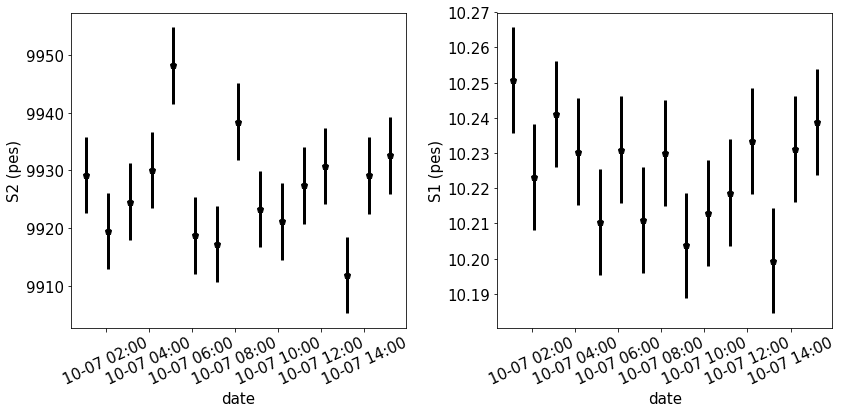

In [75]:
krf.s12_time_profile(kdstc, krNBins.T, krRanges.T, krTimes.timeStamps, figsize=(12,6))

### Time correction

In [76]:
e_mu    = np.nanmean(kdstc.E)
print(e_mu)
e_std   = np.nanstd (kdstc.E)
print(e_std)

9926.8083561
1767.88563427


In [77]:
T   =(kdstc.T - kdstc.T.min()) 
t, e, eu = fitf.profileX(T, kdstc.E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ekr = kdstc.E * ET_correction(T).value
tc, ec, euc = fitf.profileX(T, Ekr, 100)

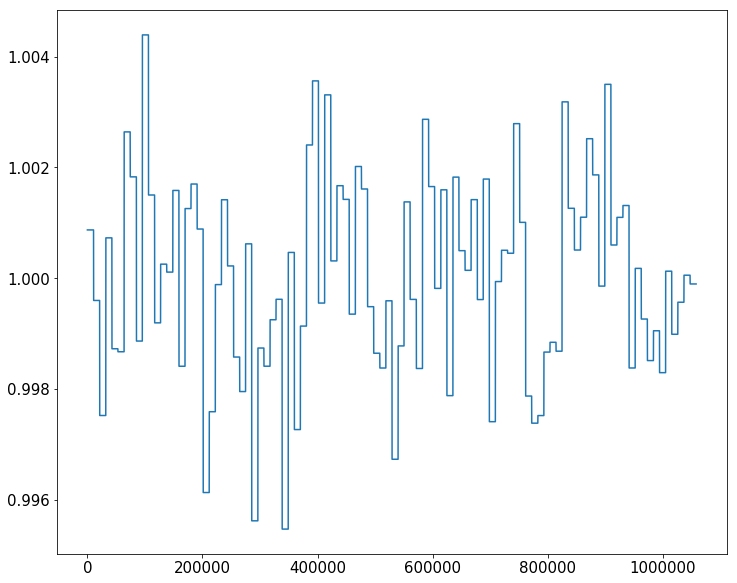

In [78]:
plt.plot(ET_correction(T).value)

In [79]:
ekr_mu    = np.nanmean(Ekr)
ekr_std   = np.nanstd (Ekr)
print(ekr_mu)
print(ekr_std)

9926.81231301
1767.81947274


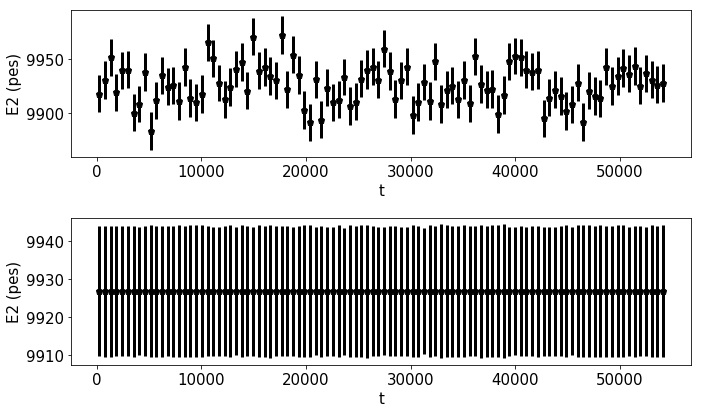

In [80]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)

plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)

plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')
plt.tight_layout()

In [81]:
#dst2 = dst[in_range(dst.T, 90e+3, 10e+4)]

In [82]:
#dst2.columns

### Notice scale. Time fluctuation below 1 %

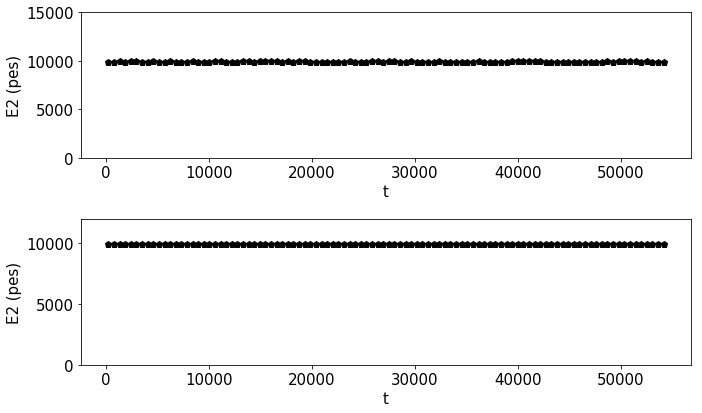

In [83]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)
plt.ylim(0, 15000)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)
plt.ylim(0, 12000)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

plt.tight_layout()



{'E lt + T corr ': Measurement(value=9927.3220261882343, uncertainty=1764.4461641896162),
 'E lt corr ': Measurement(value=9847.8308659752965, uncertainty=1793.1336925964351)}

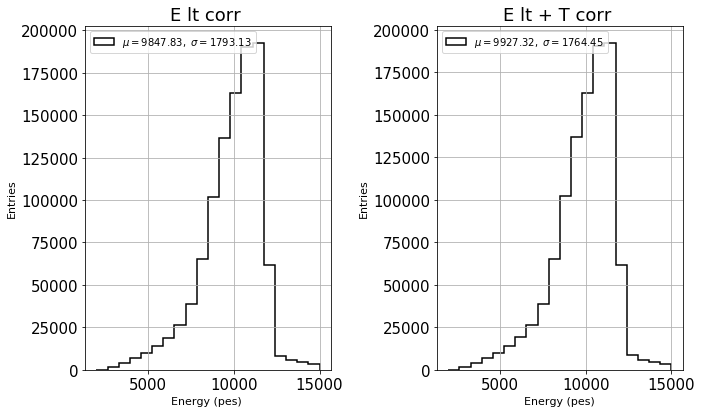

In [84]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (Ec, Ekr),
    bins = (20, 20),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    names = ("E lt corr ", "E lt + T corr "),
    titles = ("E lt corr ", "E lt + T corr "),
    legends = ("upper left", "upper left"),
    figsize =(10,6))

In [85]:
dst.S2e = Ekr

In [86]:
kdst = fiducial_volumes(dst)

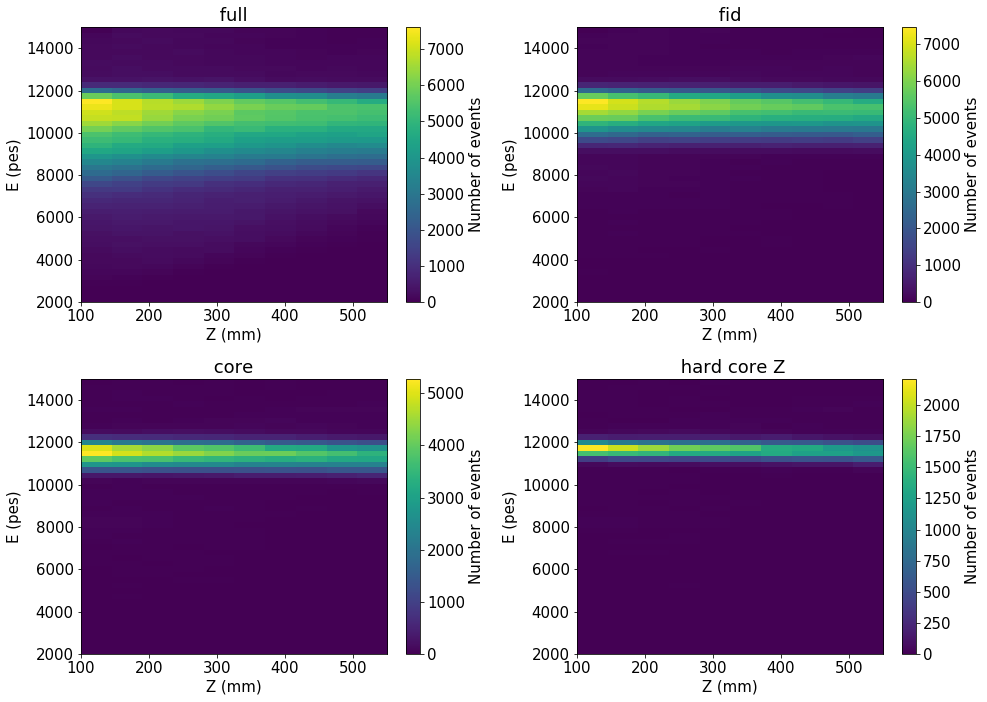

In [87]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

In [90]:
del dst["index"]

### Write LT DST

In [91]:

dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)

with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

